In [1]:
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import matplotlib.pyplot as plt
import pandas as pd

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hvgy0o_7 because the default path (/tmp/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Using Linear Least-Squares to fit GDP data

Quarterly economic data is subject to seasonal fluctuations. A curve that approximates the gross domestic product (GDP) of a country might be of the form
$$ y = \beta_0 + \beta_1 t + \beta_2 \sin\big(\frac{\pi t}{2}\big),$$
where $t$ is the time (measured in annual quarters, each of which is 3 months long), and $y$ is the GDP. The linear term $\beta_0 + \beta_1 t$ gives the basic GDP growth trend of the economy while the sine term reflects the seasonal changes.
Suppose we have $n$ GDP data points $(t_0, y_0), (t_1, y_1) \dots, (t_{n-1}, y_{n-1}).$

In this example, we will consider U.S. GDP data for each quarter since Q1 2002, courtesy of the [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ND000334Q). You are given numpy arrays `t` and `y` which compose the $n=75$ data points covering Q1 2002 through Q4 2020 (inclusive).

These data are provided as $t = [t_0, t_1, \dots, t_{n-1}]$ and $y = [y_0, y_1, \dots, y_{n-1}]$, where each $t_i$ denotes the $i$th fiscal quarter after Q1 2002 and $y_i$ denotes the corresponding GDP value for the U.S. economy in billions of USD (adjusted for inflation to 2012 USD value).

In [2]:
GDP_df = pd.read_csv("GDP_Q12002_Q42020.csv", dtype={'DATE': object, 'ND0000334Q': np.double},
                     parse_dates=True, header=0, names=['DATE','GDP'])
y = GDP_df["GDP"].to_numpy()
t = np.array(range(len(y)))

And we can plot our data for the U.S. GDP:

Text(0, 0.5, 'U.S. GDP (2012 $1B)')

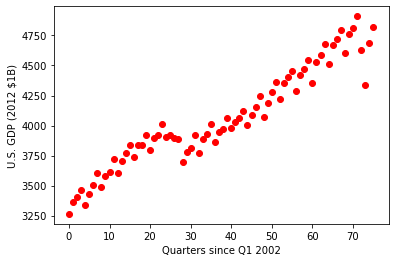

In [3]:
plt.plot(t, y, 'o', color='red')
plt.xlabel("Quarters since Q1 2002")
plt.ylabel("U.S. GDP (2012 $1B)")

Note that $t_0 = 0$ denotes $0$ fiscal quarters since Q1 2002, so $y_0$ is the (inflation-adjusted) GDP for Q1 2002. 

Similarly, $t_{31} = 31$ denotes $31$ fiscal quarters since Q1 2002, so $y_{31}$ is the GDP for Q3 2009. 

The last data point corresponds to $75^{th}$ fiscal quarter since Q1 2002, and hence $y_{75}$ is the GDP for Q4 2020. 


Check these values in the arrays!

### 1) Find the coefficients $\beta_i$ using the Linear Least Squares model:

Write a function `design_matrix` which takes as input a numpy array with shape `(n,)` that stores the values for $t$, and outputs the design matrix `A`, which leads to a least-squares fit to the equation above.
```python
def design_matrix(t):
    # t is a 1d numpy array with shape (n,) storing [t0, t1, t2, ...]
    # compute A, a 2d numpy array, following the model above
    return A
```   

In [5]:
#grade (DO NOT DELETE THIS LINE)
def design_matrix(t):
    A = np.zeros(shape=(t.shape[0], 3))
    for i in range(t.shape[0]):
        A[i, 0] = 1
        A[i, 1] = t[i]
        A[i, 2] = np.sin(np.pi * t[i]/2)
    return A

You are now supposed to compute the linear least-squares problem solution `x` given the design matrix `A` and the vector `y`, s.t. 

$${\bf A}{\bf x} \cong {\bf y}  $$

You can use the built-in function `numpy.linalg.lstsq(A,y)` function to solve the linear least-squares problem. Note that this function will return 4 different values, and the solution you want is the first one of them. Check the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) to see how you can use this function, which essentially performs the same thing as the `least_sq` function that you implemented in the Lesson 9 notebook. To prevent the function `numpy.linalg.lstsq` from returning a warning, you can use the attribute `rcond=None`.

Store the model coefficients $[\beta_0, \beta_1, \beta_2]$ as a numpy array called `coeff`.

In [10]:
#grade (DO NOT DELETE THIS LINE)
A = design_matrix(t)
coeff = np.array(la.lstsq(A, y, rcond=None))[0]


<ipython-input-10-6f2a72ced794>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coeff = np.array(la.lstsq(A, y, rcond=None))[0]


In [11]:
tt = np.linspace(0., len(y)-1, 100)
ytilde = design_matrix(tt) @ coeff

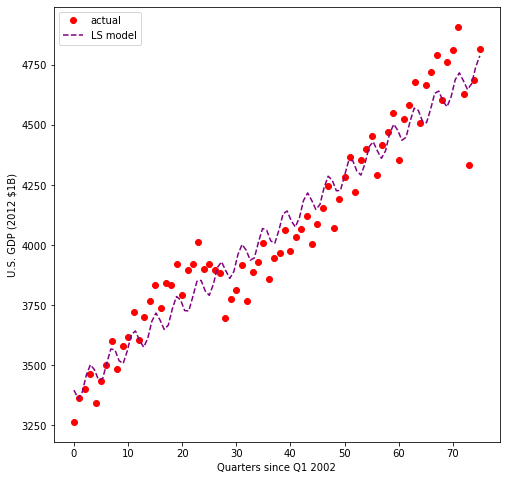

In [12]:
plt.figure(figsize=(8,8))

plt.plot(t, y, 'o', color='red', label='actual')
plt.plot(tt,ytilde , '--', color='purple', label='LS model')
plt.xlabel("Quarters since Q1 2002")
plt.ylabel("U.S. GDP (2012 $1B)")
plt.legend()

The *residual* is defined as $y - \tilde{y}$, where $y$ denotes the actual result we are seeking and $\tilde{y}$ denotes the approximated result. Hence the residual vector is ${\bf r} = {\bf y}-{\bf A x}$,

Compute the maximum absolute residual between your fitted model and the actual GDP data. Store this **scalar** value as `max_resid`.

In [18]:
#grade (DO NOT DELETE THIS LINE)
r = np.zeros(shape=(t.shape[0], 1))
tilde = design_matrix(t) @ coeff
for i in range(t.shape[0]):
    r[i] = np.abs(y[i] - tilde[i])
max_resid = max(max(r))

----------------------

### 2) Removing the "outlier" events

By inspecting the plot, we might recall two major events which deeply impacted the U.S. economy during the timeframe covered by our data points: the Global Financial Crisis (GFC) of 2007-2008, caused by excessive risk-taking by banks and the bursting of the U.S. housing bubble, and the current COVID-19 pandemic. Let's consider a time period *between* these events to better capture the basic GDP trend of the U.S. economy. This will help us understand economic trends during times of relative normalcy.

**Extract (from `y`) the GDP data starting with Q3 2009 and ending with Q1 2020 (inclusive). Store this as a numpy array `y_normal`.**

*Hint: `t[31]` corresponds to Q3 2009. Which index of `t` corresponds to Q1 2020?*

In [22]:
#grade (DO NOT DELETE THIS LINE)
y_normal = y[31:73]

We provide the re-indexed `t_normal` $= [t'_0, t'_1, \dots, t'_m]$ such that $t'_i$ denotes the $i$th fiscal quarter since Q3 2009. Use this array with your `y_normal` to re-run the analysis. 

In [23]:
t_normal = np.arange(len(y_normal))
t_normal

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41])

Find the coefficients for the model representing the least-squares fit to these "normal" data points (data that fits `t_normal` and `y_normal`).

These coefficients should be stored as a 1d numpy array `x_normal`, the solution of the linear least-squares problem.

Find and store the maximum absolute residual as `max_resid_normal`.

In [27]:
#grade (DO NOT DELETE THIS LINE)
A = design_matrix(t_normal)
x_normal = np.array(la.lstsq(A, y_normal, rcond=None))[0]

r = np.zeros(shape=(t_normal.shape[0], 1))
tilde = design_matrix(t_normal) @ x_normal
for i in range(t_normal.shape[0]):
    r[i] = np.abs(y_normal[i] - tilde[i])
max_resid_normal = max(max(r))

<ipython-input-27-e7a14bb059e7>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_normal = np.array(la.lstsq(A, y_normal, rcond=None))[0]


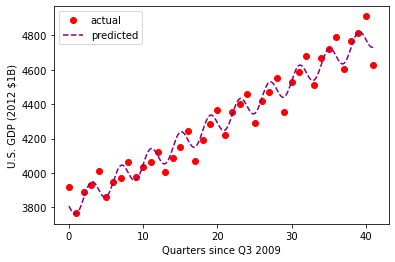

In [25]:
tt = np.linspace(0., len(y_normal)-1, num=10**3)
plt.plot(t_normal, y_normal, 'o', color='red', label='actual')
plt.plot(tt, design_matrix(tt) @ x_normal, '--', color='purple', label='predicted')
plt.xlabel("Quarters since Q3 2009")
plt.ylabel("U.S. GDP (2012 $1B)")
plt.legend()

----------------------

### 3) Making predictions

What happens if we disregard the coefficient $\beta_2$ in our model? So instead of 

$$ y = \beta_0 + \beta_1 t + \beta_2 \sin\big(\frac{\pi t}{2}\big)$$

we would use

$$ y = \beta_0 + \beta_1 t $$

which would give us a straight line that fits the data points. Note that, in general, we would need to compute the linear least-squares solution using this other model (new design matrix ${\bf A}$ resulting in new coefficients $\beta_0$ and $\beta_1$). However, in this example, since the oscillations are very small, we can just approximate our new fit using the coefficients $\beta_0$ and $\beta_1$ obtained in the previous section (you can check that indeed this is a very good approximation).


In [28]:
tt = np.linspace(0., len(y_normal)-1, num=10**3)
new_fit = x_normal[0] + x_normal[1]*tt

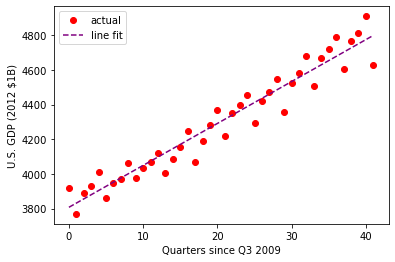

In [29]:
plt.plot(t_normal, y_normal, 'o', color='red', label='actual')
plt.plot(tt, new_fit, '--', color='purple', label='line fit')
plt.xlabel("Quarters since Q3 2009")
plt.ylabel("U.S. GDP (2012 $1B)")
plt.legend()

Recall that the model above (labeled as `line fit`) is only using data from Q3 2009 and ending with Q1 2020 (which avoids the impact of COVID). Use this model to predict the GDP in the following quarters:

Store in `y2020q2` the GDP in Q2 2020.

Store in `y2020q3` the GDP in Q3 2020.

Store in `y2020q4` the GDP in Q4 2020.

Store in `y2021q1` the GDP in Q1 2021.

In [30]:
#grade (DO NOT DELETE THIS LINE)
y2020q2 = x_normal[0] + x_normal[1]*42
y2020q3 = x_normal[0] + x_normal[1]*43
y2020q4 = x_normal[0] + x_normal[1]*44
y2021q1 = x_normal[0] + x_normal[1]*45

How good are the predictions using this model? We can already compare the data for Q2, Q3, and Q4 of last year. You can come back to this example once the data for Q1 2021 has been finalized, and compare your results :-).

In [31]:
print('Actual GDP for Q2 2020: ' , y[-3])
print('Predicted GDP for Q2 2020: ' , y2020q2)

Actual GDP for Q2 2020:  4333.81
Predicted GDP for Q2 2020:  4823.608613767703


In [32]:
print('Actual GDP for Q3 2020: ' , y[-2])
print('Predicted GDP for Q3 2020: ' , y2020q3)

Actual GDP for Q3 2020:  4687.826
Predicted GDP for Q3 2020:  4847.800843137851


In [33]:
print('Actual GDP for Q4 2020: ' , y[-1])
print('Predicted GDP for Q4 2020: ' , y2020q4)

Actual GDP for Q4 2020:  4818.083
Predicted GDP for Q4 2020:  4871.993072507999
